In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

#Import Model Packages 
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import inv, eig, svd

from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA

In [19]:
import yfinance as yf
dow30 = ['MMM','AXP','JPM','GS','AAPL','CAT','CVX','PG','UNH','AMGN','BA','CSCO','HD','HON','IBM','INTC','JNJ','KO','MCD','MRK','MSFT','NKE','TRV','CRM','VZ','V','WMT','DIS','DOW']

dataset = yf.download(dow30,period='10y',order_by='tickers')

[*********************100%***********************]  29 of 29 completedleted
[***************************************176%*****************************************]  51 of 29 completed

In [20]:
dataset = dataset.Close

#dataset = dataset.dropna()
dataset.shape

(2517, 29)

In [24]:
dataset
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)
missing_fractions

drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))

drop = list(missing_fractions[missing_fractions > .3].index)

                                #Col
dataset.drop(labels=drop_list, axis=1, inplace=True)

In [25]:
# Fill the missing values with the last value available in the dataset. 
dataset=dataset.fillna(method='ffill')

In [28]:
# Daily Linear Returns (%)
datareturns = dataset.pct_change(1)

#Remove Outliers beyong 3 standard deviation
datareturns= datareturns[datareturns.apply(lambda x :(x-x.mean()).abs()<(3*x.std()) ).all(1)]

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(datareturns)
rescaledDataset = pd.DataFrame(scaler.fit_transform(datareturns),columns = datareturns.columns, index = datareturns.index)
# summarize transformed data
datareturns.dropna(how='any', inplace=True)
rescaledDataset.dropna(how='any', inplace=True)
rescaledDataset.head(2)

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MMM,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2011-02-25,0.981485,1.969962,-0.100664,1.420127,0.928535,1.872145,1.234173,0.046062,1.028679,0.686101,...,0.180265,0.430619,-0.754262,1.292440,-0.468420,0.397025,-0.508889,0.760662,1.116660,-0.770424
2011-02-28,0.918713,-1.477814,0.033524,-0.322169,0.581649,-2.779322,-0.422478,1.259622,1.540775,-0.598928,...,2.065116,1.089284,0.005280,0.890337,0.353814,0.494159,0.029783,-1.947450,2.739902,0.443662


<Figure size 1152x360 with 0 Axes>

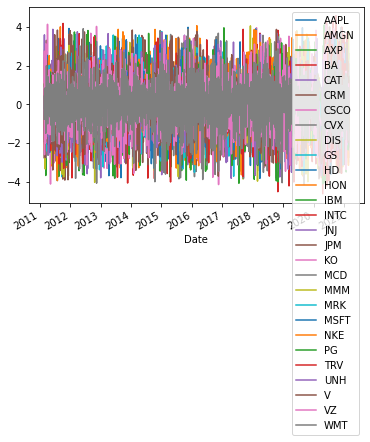

In [39]:
# Visualizing Log Returns for the DJIA 
#plt.figure(figsize=(16, 5))
#plt.title("AAPL Return")
#plt.ylabel("Return")
plt.figure(figsize=(16, 5))
rescaledDataset.plot()
#plt.grid(True);
plt.legend()

#plt.show()

In [40]:
# Dividing the dataset into training and testing sets
percentage = int(len(rescaledDataset) * 0.8)
X_train = rescaledDataset[:percentage]
X_test = rescaledDataset[percentage:]

X_train_raw = datareturns[:percentage]
X_test_raw = datareturns[percentage:]


stock_tickers = rescaledDataset.columns.values
n_tickers = len(stock_tickers)

In [43]:
'''PCA !!'''
pca = PCA()
PrincipalComponent=pca.fit(X_train)

In [44]:
#FIRST PC / Eigenvector
pca.components_[0]

array([0.14450138, 0.1837245 , 0.21173812, 0.16943566, 0.19789701,
       0.16521775, 0.20173772, 0.18127324, 0.2005218 , 0.20976871,
       0.19282796, 0.23650717, 0.20447454, 0.18498692, 0.19948167,
       0.22089174, 0.17700324, 0.1580207 , 0.22917043, 0.17501513,
       0.19327252, 0.17301886, 0.17207812, 0.19693682, 0.17095151,
       0.19958225, 0.15832735, 0.14352282])

In [48]:
len(pca.components_)

28

,Explained Variance
0,41.61%
1,47.65%
2,51.67%
3,55.18%
4,58.44%
5,61.19%
6,63.88%
7,66.41%
8,68.86%
9,71.18%


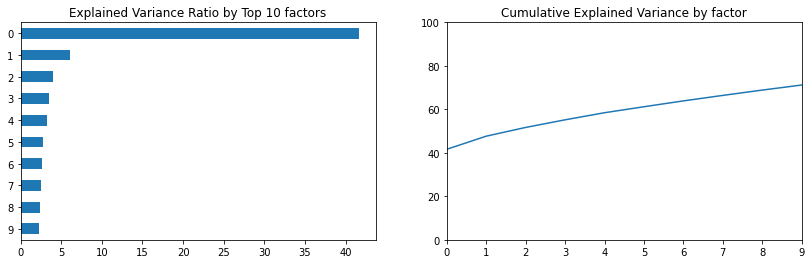

In [46]:
#Explained Variance per EigenVector
NumEigenvalues=10
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
Series1 = pd.Series(pca.explained_variance_ratio_[:NumEigenvalues]).sort_values()*100
Series2 = pd.Series(pca.explained_variance_ratio_[:NumEigenvalues]).cumsum()*100
Series1.plot.barh(ylim=(0,9), label="woohoo",title='Explained Variance Ratio by Top 10 factors',ax=axes[0]);
Series2.plot(ylim=(0,100),xlim=(0,9),ax=axes[1], title='Cumulative Explained Variance by factor');
# explained_variance
pd.Series(np.cumsum(pca.explained_variance_ratio_)).to_frame('Explained Variance').head(NumEigenvalues).style.format('{:,.2%}'.format)

In [52]:
def PCWeights():
    '''
    Principal Components (PC) weights for each 28 PCs
    '''
    weights = pd.DataFrame()

    for i in range(len(pca.components_)):
        weights["weights_{}".format(i)] = pca.components_[i] / sum(pca.components_[i])

    weights = weights.values.T
    return weights

weights=PCWeights()
print(pca.components_[0])
weights[0]

[0.14450138 0.1837245  0.21173812 0.16943566 0.19789701 0.16521775
 0.20173772 0.18127324 0.2005218  0.20976871 0.19282796 0.23650717
 0.20447454 0.18498692 0.19948167 0.22089174 0.17700324 0.1580207
 0.22917043 0.17501513 0.19327252 0.17301886 0.17207812 0.19693682
 0.17095151 0.19958225 0.15832735 0.14352282]


array([0.02751419, 0.03498258, 0.04031659, 0.03226187, 0.03768113,
       0.03145875, 0.03841244, 0.03451584, 0.03818091, 0.0399416 ,
       0.03671595, 0.04503281, 0.03893355, 0.03522295, 0.03798287,
       0.04205951, 0.0337028 , 0.03008837, 0.04363584, 0.03332425,
       0.0368006 , 0.03294414, 0.03276502, 0.03749831, 0.0325505 ,
       0.03800202, 0.03014676, 0.02732786])

       AAPL      AMGN       AXP        BA       CAT       CRM      CSCO  \
0  0.144501  0.183724  0.211738  0.169436  0.197897  0.165218  0.201738   
1  0.186177 -0.168571  0.118903  0.077009  0.234839  0.254849  0.155551   
2 -0.311150 -0.173554  0.133391  0.073401  0.187510 -0.383055 -0.109372   
3 -0.277205  0.289429  0.170677 -0.000220 -0.221135  0.038775 -0.192273   
4 -0.033707 -0.479204  0.115271  0.023843  0.020724 -0.056151 -0.094897   

        CVX       DIS        GS  ...       MMM       MRK      MSFT       NKE  \
0  0.181273  0.200522  0.209769  ...  0.229170  0.175015  0.193273  0.173019   
1  0.058326  0.016593  0.268426  ...  0.013903 -0.253675  0.118848 -0.004958   
2  0.283708  0.016491  0.305537  ...  0.095441  0.009621 -0.247072 -0.281405   
3 -0.249111  0.099761  0.240649  ... -0.071686  0.087662 -0.207633  0.276384   
4 -0.066383  0.114993  0.009809  ...  0.016712 -0.466008 -0.033357  0.329231   

         PG       TRV       UNH         V        VZ       WMT  
0  0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa8f13ef110>],
      dtype=object)

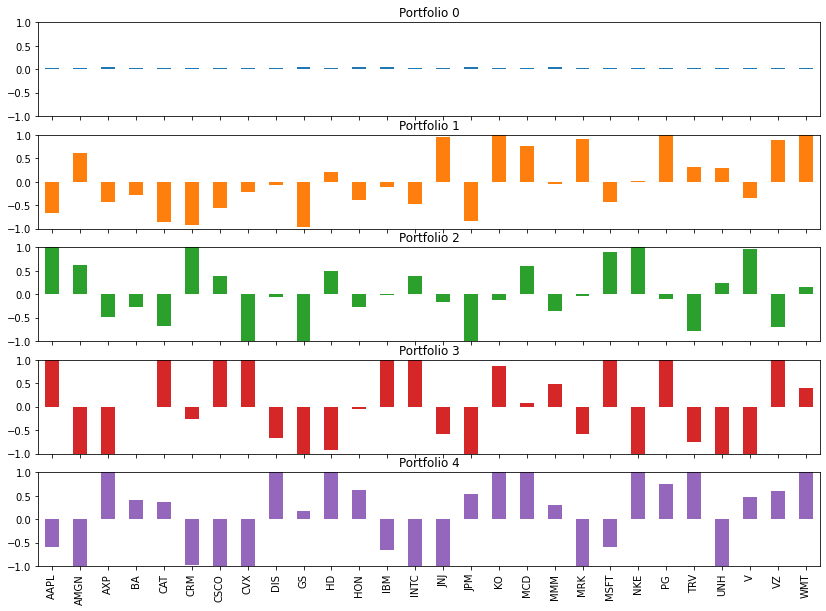

In [54]:
NumComponents=5
        
topPortfolios = pd.DataFrame(pca.components_[:NumComponents], columns=dataset.columns)
print(topPortfolios.head(5))
#Divide obs by the SUM of ROW (so... make each row sum to 1.0)
eigen_portfolios = topPortfolios.div(topPortfolios.sum(1), axis=0)

print(eigen_portfolios.head(5))
eigen_portfolios.index = [f'Portfolio {i}' for i in range( NumComponents)]
np.sqrt(pca.explained_variance_)
eigen_portfolios.T.plot.bar(subplots=True, layout=(int(NumComponents),1), figsize=(14,10), legend=False, sharey=True, ylim= (-1,1))

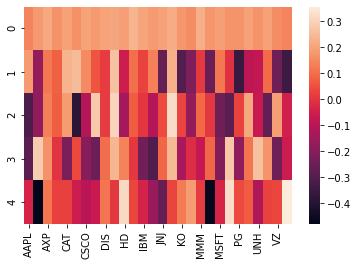

In [60]:
# #eigen_portfolios = topPortfolios.div(topPortfolios.sum(1), axis=0)
# df=pd.DataFrame({'A':[1,2,3],'B':[4,5,6]})
# df.div(df.sum(1),axis=0)

# plotting heatmap 
sns.heatmap(topPortfolios)

In [61]:
# Sharpe Ratio
def sharpe_ratio(ts_returns, periods_per_year=252):
    '''
    Sharpe ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk.
    It calculares the annualized return, annualized volatility, and annualized sharpe ratio.
    
    ts_returns are  returns of a signle eigen portfolio.
    '''
    n_years = ts_returns.shape[0]/periods_per_year
    annualized_return = np.power(np.prod(1+ts_returns),(1/n_years))-1
    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol

    return annualized_return, annualized_vol, annualized_sharpe

Eigen portfolio #0 with the highest Sharpe. Return 13.76%, vol = 11.61%, Sharpe = 1.19
      Return       Vol    Sharpe
0   0.137627  0.116058  1.185845
13  0.418625  0.767371  0.545531
23  0.338349  0.826690  0.409281
2   0.140357  0.561312  0.250051
1   0.123815  0.713080  0.173634
25  0.053375  1.013728  0.052652
8  -0.014941  0.799422 -0.018690
3  -0.122628  1.038427 -0.118090
10 -1.000000  5.871104 -0.170326
14 -1.000000  5.300075 -0.188677
16 -0.999848  4.327940 -0.231022
11 -0.414285  1.757481 -0.235727
24 -0.999832  3.791673 -0.263692
21 -0.962236  2.997785 -0.320982
20 -0.515514  1.450734 -0.355347
4  -0.966865  2.562739 -0.377278
17 -0.596948  1.566990 -0.380952
15 -0.359928  0.902443 -0.398838
7  -0.969457  2.278129 -0.425550
19 -0.941388  2.201561 -0.427600


/Users/zoakes/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in power
  # Remove the CWD from sys.path while we load stuff.


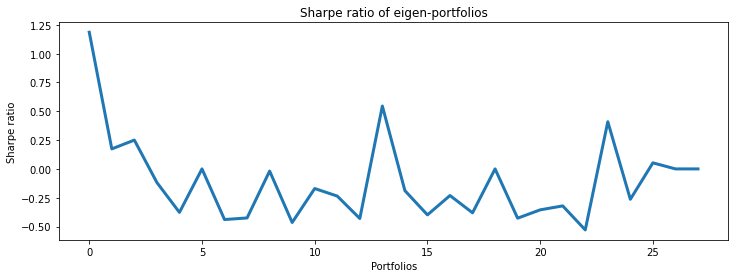

In [64]:
def optimizedPortfolio():
    #Initialize Arrays for saving values
    n_portfolios = len(pca.components_)
    annualized_ret = np.array([0.] * n_portfolios)
    sharpe_metric = np.array([0.] * n_portfolios)
    annualized_vol = np.array([0.] * n_portfolios)
    highest_sharpe = 0 
    stock_tickers = rescaledDataset.columns.values
    n_tickers = len(stock_tickers)
    pcs = pca.components_
    
    for i in range(n_portfolios):
        pc_w = pcs[i] / sum(pcs[i])
        #print(pc_w,pc_w.squeeze() * 100)
        eigen_prtfi = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
        eigen_prtfi.sort_values(by=['weights'], ascending=False, inplace=True)
        eigen_prti_returns = np.dot(X_train_raw.loc[:, eigen_prtfi.index], pc_w)
        eigen_prti_returns = pd.Series(eigen_prti_returns.squeeze(), index=X_train_raw.index)
        er, vol, sharpe = sharpe_ratio(eigen_prti_returns)
        annualized_ret[i] = er
        annualized_vol[i] = vol
        sharpe_metric[i] = sharpe
        
        sharpe_metric= np.nan_to_num(sharpe_metric)
        
    # find portfolio with the highest Sharpe ratio
    highest_sharpe = np.argmax(sharpe_metric)
    
    print('Eigen portfolio #%d with the highest Sharpe. Return %.2f%%, vol = %.2f%%, Sharpe = %.2f' % 
          (highest_sharpe,
           annualized_ret[highest_sharpe]*100, 
           annualized_vol[highest_sharpe]*100, 
           sharpe_metric[highest_sharpe]))
    
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    ax.plot(sharpe_metric, linewidth=3)
    ax.set_title('Sharpe ratio of eigen-portfolios')
    ax.set_ylabel('Sharpe ratio')
    ax.set_xlabel('Portfolios')

    results = pd.DataFrame(data={'Return': annualized_ret, 'Vol': annualized_vol, 'Sharpe': sharpe_metric})
    results.dropna(inplace=True)
    results.sort_values(by=['Sharpe'], ascending=False, inplace=True)
    print(results.head(20))

    plt.show()
    
optimizedPortfolio()

In [88]:
# pcs = pca.components_
# print(pcs[0])
# pc_w = pcs[0] / sum(pcs[0])
# print(pc_w)
# #pc_w.squeeze() * 100

# stock_tickers = rescaledDataset.columns.values
# eigen_prtfi = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
# eigen_prtfi


#eigen_prti_returns = np.dot(X_train_raw.loc[:, eigen_prtfi.index], pc_w)
#eigen_prti_returns

#ONLY get symbols IN FILTERED portfolio (bc using RAW percents...)
#np.dot(X_train_raw.loc[:,eigen_prtfi.index],pc_w) 
#Multiplies the AAPL wt x AAPL col, + sums it. Then AMGN wt x AMGN, sum etc.

# print(pc_w)
# X_train_raw.head(3)

Sum of weights of current eigen-portfolio: 100.00


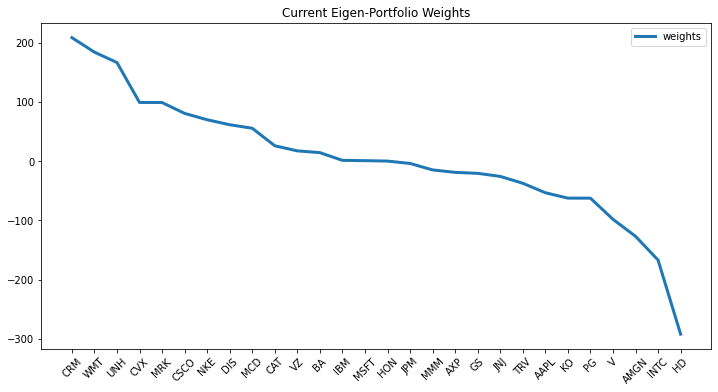

,weights
CRM,208.269877
WMT,183.836795
UNH,166.252436
CVX,98.992678
MRK,98.859788
CSCO,80.503311
NKE,69.804975
DIS,61.395789
MCD,55.465874
CAT,25.897494


In [96]:
weights = PCWeights()
portfolio = portfolio = pd.DataFrame()


def plotEigen(weights, plot=False, portfolio=portfolio):
    portfolio = pd.DataFrame(data ={'weights': weights.squeeze()*100}, index = stock_tickers) 
    portfolio.sort_values(by=['weights'], ascending=False, inplace=True)
    if plot:
        print('Sum of weights of current eigen-portfolio: %.2f' % np.sum(portfolio))
        portfolio.plot(title='Current Eigen-Portfolio Weights', 
            figsize=(12,6), 
            xticks=range(0, len(stock_tickers),1), 
            rot=45, 
            linewidth=3
            )
        plt.show()


    return portfolio

# Weights are stored in arrays, where 0 is the first PC's weights.
plotEigen(weights=weights[13], plot=True)

EigenVector Portfolio 0
Current Eigen-Portfolio:
Return = 36.11%
Volatility = 11.91%
Sharpe = 3.03


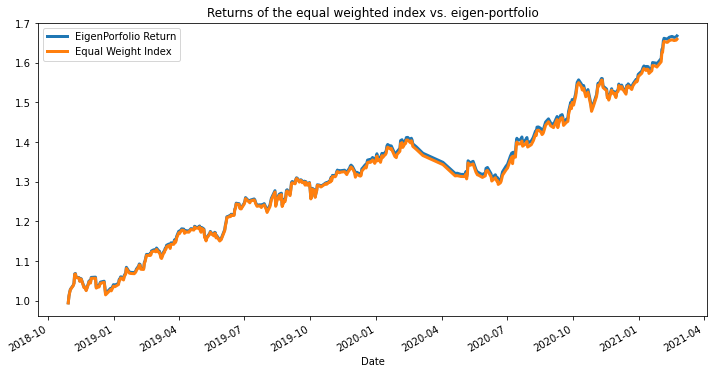

EigenVector Portfolio 1
Current Eigen-Portfolio:
Return = 224.46%
Volatility = 87.93%
Sharpe = 2.55


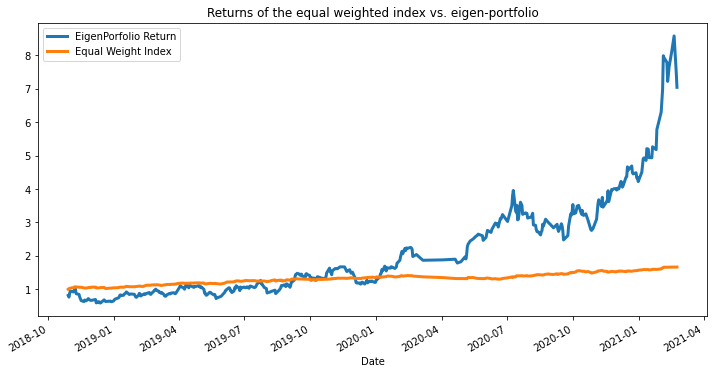

EigenVector Portfolio 2
Current Eigen-Portfolio:
Return = -34.16%
Volatility = 60.93%
Sharpe = -0.56


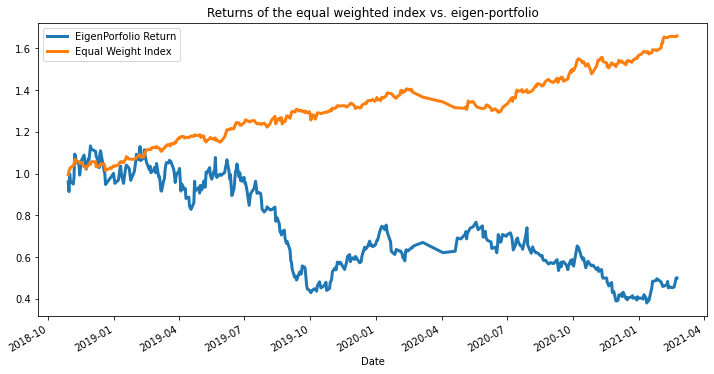

EigenVector Portfolio 3
Current Eigen-Portfolio:
Return = 30.87%
Volatility = 125.51%
Sharpe = 0.25


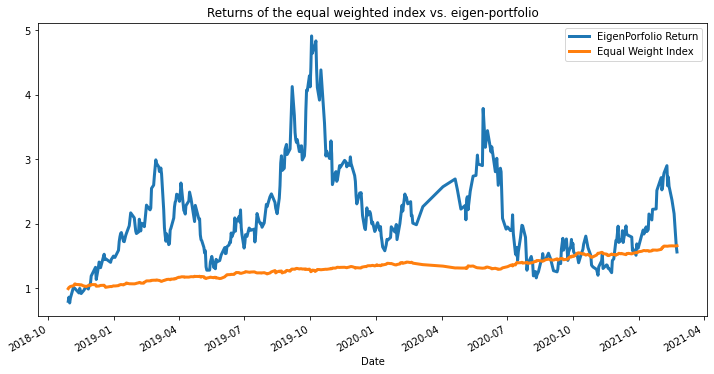

EigenVector Portfolio 4
Current Eigen-Portfolio:
Return = -99.97%
Volatility = 325.25%
Sharpe = -0.31


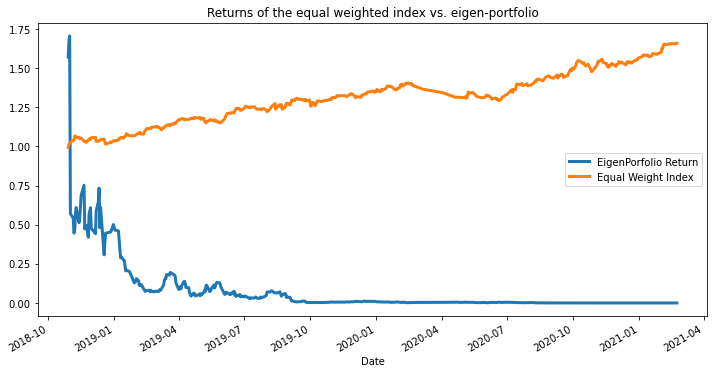

EigenVector Portfolio 5
Current Eigen-Portfolio:
Return = 5581695878949969592320.00%
Volatility = 3562.01%
Sharpe = 1567008894278379776.00


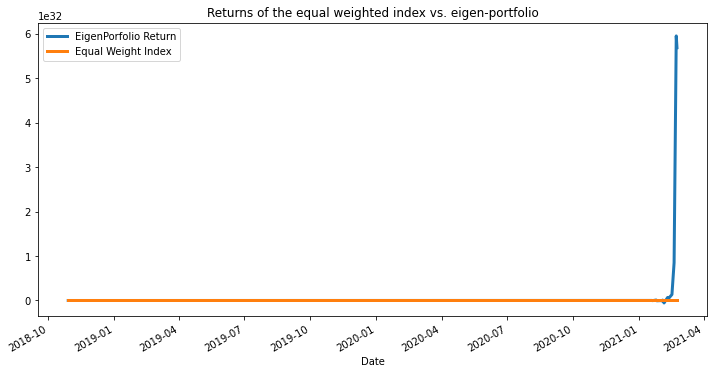

EigenVector Portfolio 6
Current Eigen-Portfolio:
Return = -12.21%
Volatility = 171.23%
Sharpe = -0.07


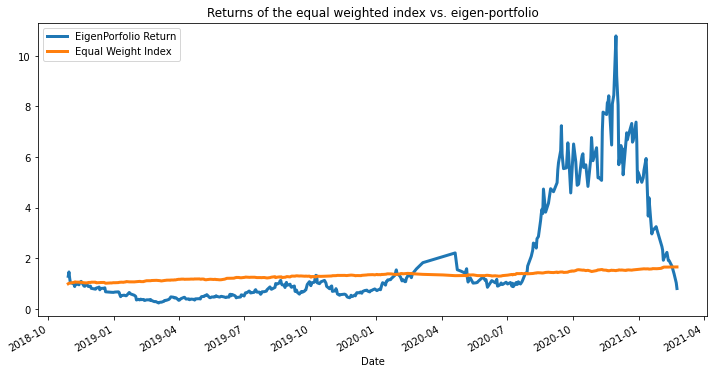

EigenVector Portfolio 7
Current Eigen-Portfolio:
Return = -100.00%
Volatility = 285.66%
Sharpe = -0.35


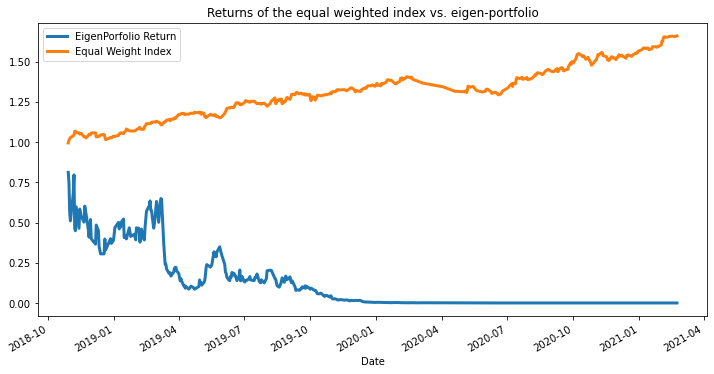

EigenVector Portfolio 8
Current Eigen-Portfolio:
Return = 509.55%
Volatility = 112.49%
Sharpe = 4.53


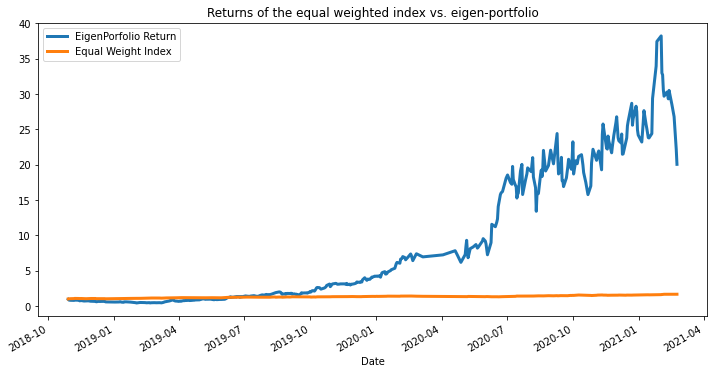

EigenVector Portfolio 9
Current Eigen-Portfolio:
Return = -99.94%
Volatility = 252.56%
Sharpe = -0.40


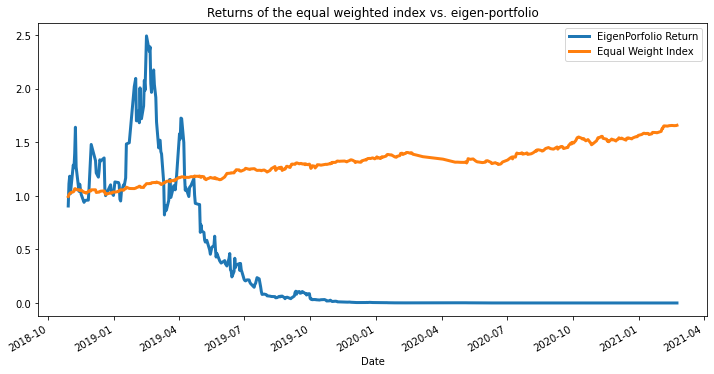

EigenVector Portfolio 10
Current Eigen-Portfolio:
Return = -100.00%
Volatility = 734.29%
Sharpe = -0.14


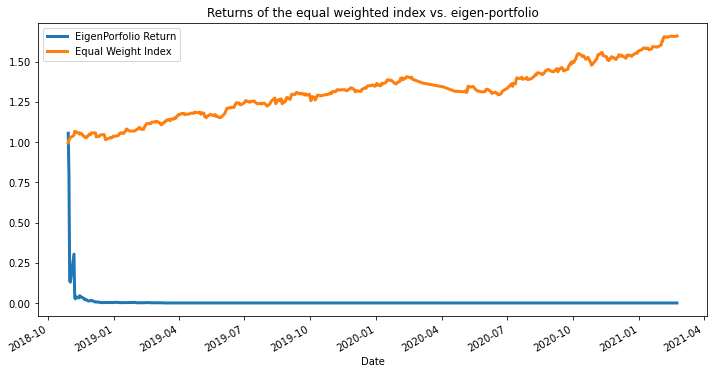

EigenVector Portfolio 11
Current Eigen-Portfolio:
Return = 530.89%
Volatility = 221.67%
Sharpe = 2.39


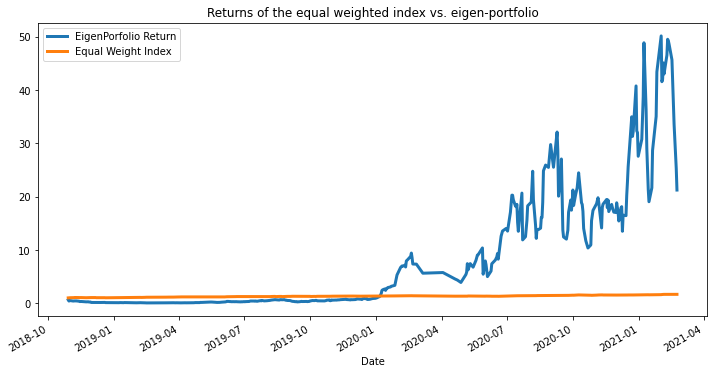

EigenVector Portfolio 12
Current Eigen-Portfolio:
Return = 124.07%
Volatility = 182.79%
Sharpe = 0.68


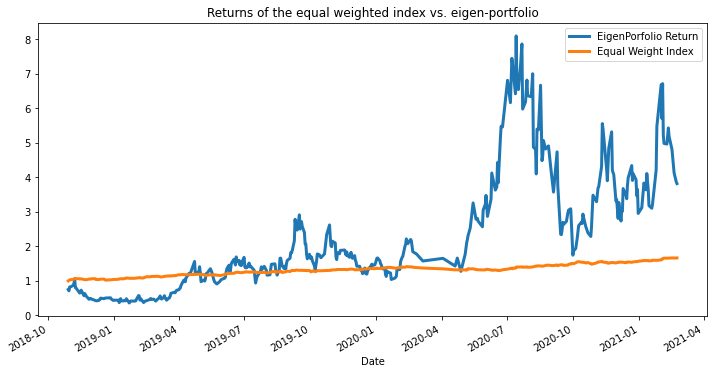

EigenVector Portfolio 13
Current Eigen-Portfolio:
Return = 257.20%
Volatility = 88.37%
Sharpe = 2.91


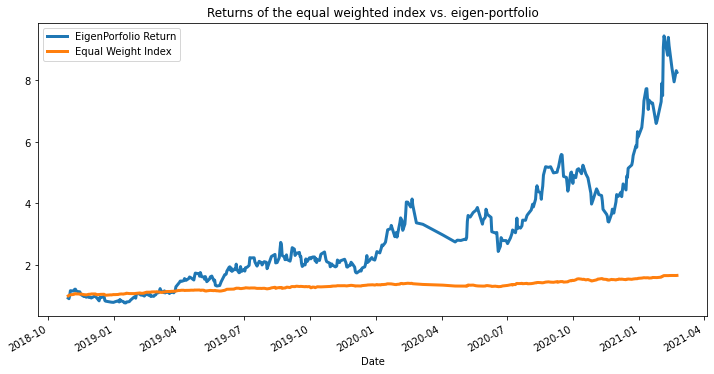

EigenVector Portfolio 14
Current Eigen-Portfolio:
Return = -100.00%
Volatility = 646.53%
Sharpe = -0.15


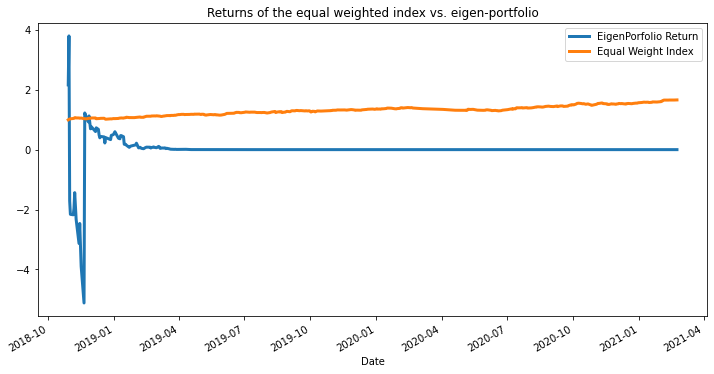

EigenVector Portfolio 15
Current Eigen-Portfolio:
Return = -44.06%
Volatility = 101.70%
Sharpe = -0.43


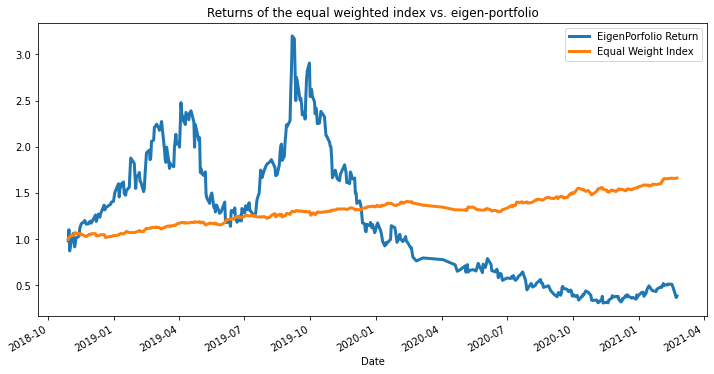

EigenVector Portfolio 16
Current Eigen-Portfolio:
Return = nan%
Volatility = 475.23%
Sharpe = nan


/Users/zoakes/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in power
  # Remove the CWD from sys.path while we load stuff.


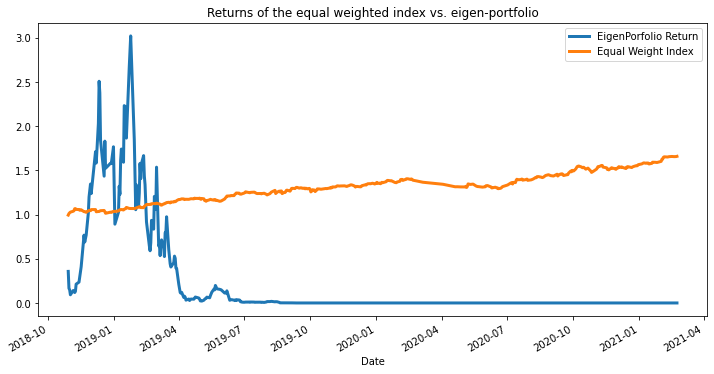

EigenVector Portfolio 17
Current Eigen-Portfolio:
Return = 419.47%
Volatility = 208.33%
Sharpe = 2.01


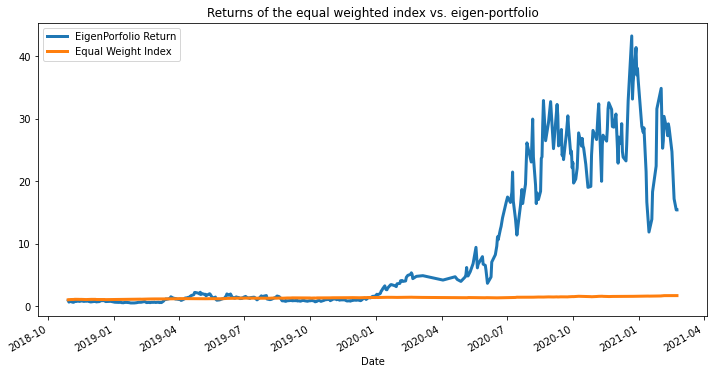

EigenVector Portfolio 18
Current Eigen-Portfolio:
Return = nan%
Volatility = 682.88%
Sharpe = nan


/Users/zoakes/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in power
  # Remove the CWD from sys.path while we load stuff.


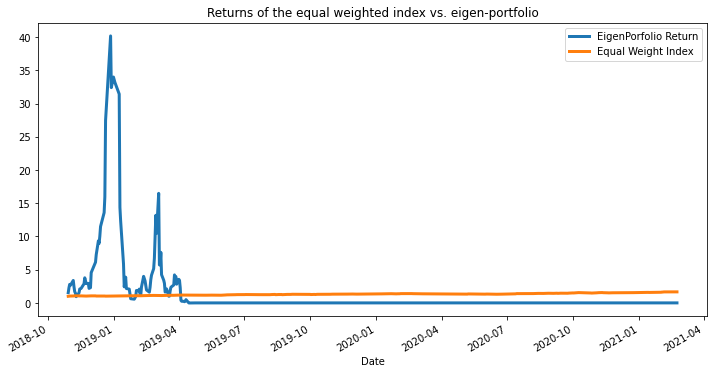

EigenVector Portfolio 19
Current Eigen-Portfolio:
Return = -99.94%
Volatility = 272.53%
Sharpe = -0.37


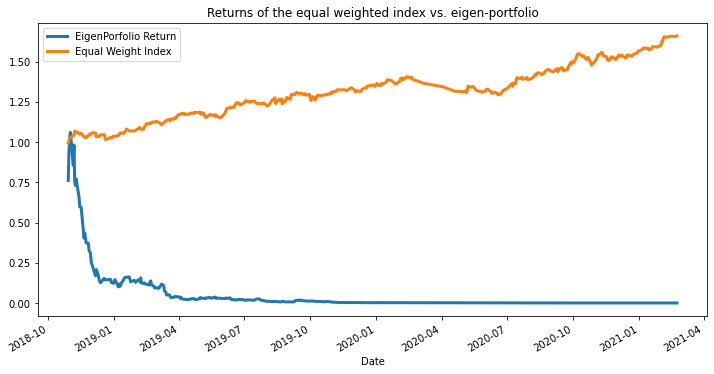

EigenVector Portfolio 20
Current Eigen-Portfolio:
Return = -88.30%
Volatility = 166.33%
Sharpe = -0.53


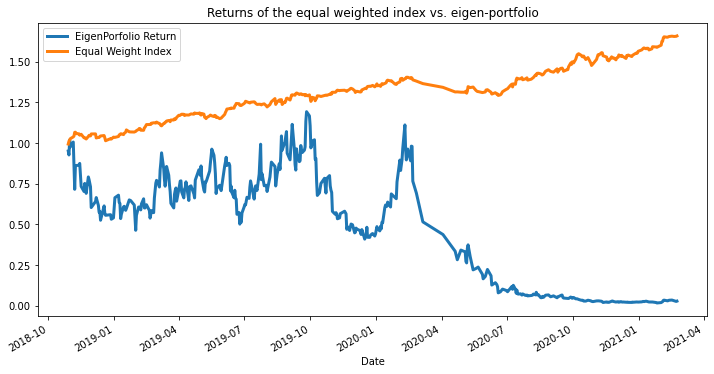

EigenVector Portfolio 21
Current Eigen-Portfolio:
Return = -99.69%
Volatility = 396.94%
Sharpe = -0.25


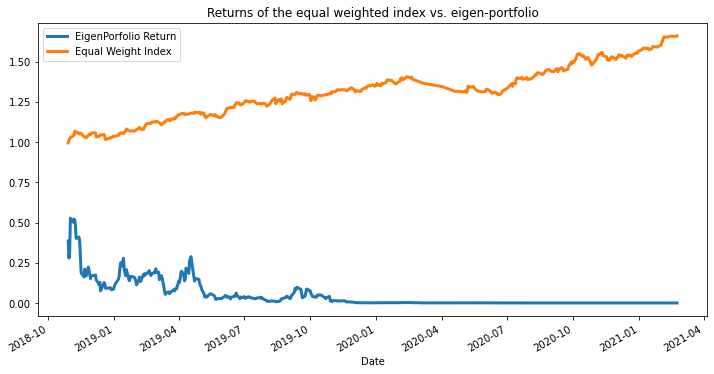

EigenVector Portfolio 22
Current Eigen-Portfolio:
Return = -95.07%
Volatility = 216.65%
Sharpe = -0.44


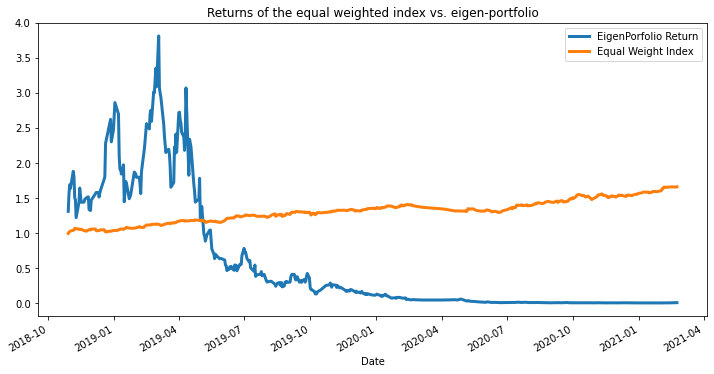

EigenVector Portfolio 23
Current Eigen-Portfolio:
Return = 345.65%
Volatility = 90.86%
Sharpe = 3.80


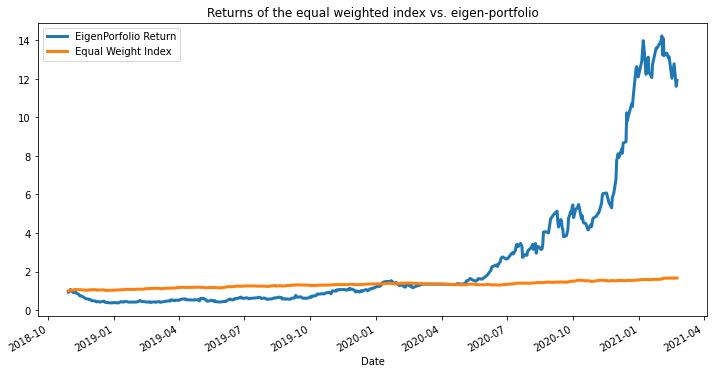

EigenVector Portfolio 24
Current Eigen-Portfolio:
Return = -100.00%
Volatility = 405.35%
Sharpe = -0.25


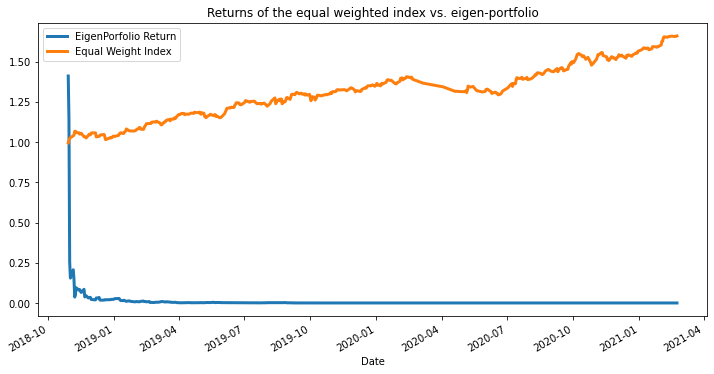

EigenVector Portfolio 25
Current Eigen-Portfolio:
Return = -63.43%
Volatility = 110.11%
Sharpe = -0.58


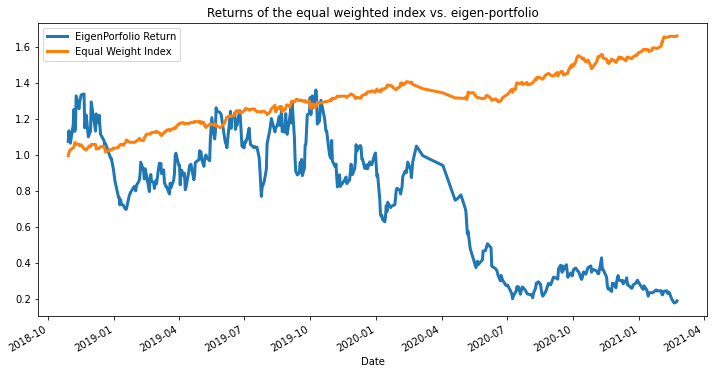

EigenVector Portfolio 26
Current Eigen-Portfolio:
Return = nan%
Volatility = 4102.73%
Sharpe = nan


/Users/zoakes/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in power
  # Remove the CWD from sys.path while we load stuff.


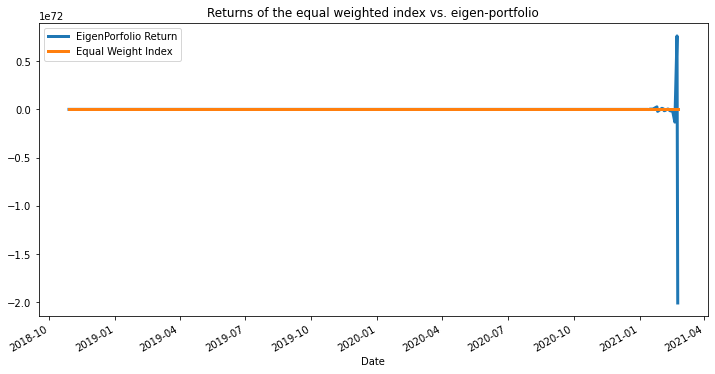

EigenVector Portfolio 27
Current Eigen-Portfolio:
Return = -100.00%
Volatility = 462.20%
Sharpe = -0.22


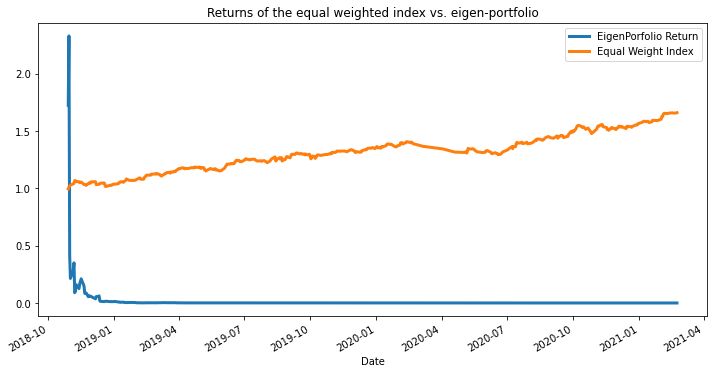

In [100]:
def Backtest(eigen):
    '''
    Plots Principle components returns against real returns.
    '''
   
    eigen_prtfi = pd.DataFrame(data ={'weights': eigen.squeeze()}, index = stock_tickers)
    eigen_prtfi.sort_values(by=['weights'], ascending=False, inplace=True)    

    eigen_prti_returns = np.dot(X_test_raw.loc[:, eigen_prtfi.index], eigen)
    eigen_portfolio_returns = pd.Series(eigen_prti_returns.squeeze(), index=X_test_raw.index)
    returns, vol, sharpe = sharpe_ratio(eigen_portfolio_returns)  
    print('Current Eigen-Portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (returns*100, vol*100, sharpe))
    equal_weight_return=(X_test_raw * (1/len(pca.components_))).sum(axis=1)    
    df_plot = pd.DataFrame({'EigenPorfolio Return': eigen_portfolio_returns, 'Equal Weight Index': equal_weight_return}, index=X_test.index)
    np.cumprod(df_plot + 1).plot(title='Returns of the equal weighted index vs. eigen-portfolio' , 
                          figsize=(12,6), linewidth=3)
    plt.show()
    
for i in range(len(weights)):
    print(f"EigenVector Portfolio {i}")
    Backtest(eigen=weights[i])
    
#Backtest(eigen=weights[5])
#Backtest(eigen=weights[1])
#Backtest(eigen=weights[14])

In [105]:
#print(weights[5])
#print(stock_tickers[5])